In [11]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import skew

In [12]:
df_raw= pd.read_csv('../data/House_Rent_Dataset.csv')
#convertir columnnas a lowercase
df_raw.columns = df_raw.columns.str.lower()

In [13]:
df_raw.head(5)

,posted on,bhk,rent,size,floor,area type,area locality,city,furnishing status,tenant preferred,bathroom,point of contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


## 1. Data Cleaning, Analysis and Preparation

In [14]:
df_raw.isnull().sum()

posted on            0
bhk                  0
rent                 0
size                 0
floor                0
area type            0
area locality        0
city                 0
furnishing status    0
tenant preferred     0
bathroom             0
point of contact     0
dtype: int64

In [15]:
df_raw.describe()

,bhk,rent,size,bathroom
count,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2.083860,3.499345e+04,967.490729,1.965866
std,0.832256,7.810641e+04,634.202328,0.884532
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


A partir del análisis de `.describe()`, se observa que las variables **rent** y **size** presentan una distribución sesgada hacia la derecha, lo que indica la presencia de valores atípicos extremos.  
Antes de proceder con el modelado, será necesario procesar estos valores atípicos y, posiblemente, aplicar una **transformación logarítmica** tanto a la renta como al tamaño para mejorar la distribución y el desempeño de los modelos.

In [16]:
df_raw.select_dtypes(include=['object']).nunique().sort_values(ascending=False)

area locality        2235
floor                 480
posted on              81
city                    6
area type               3
furnishing status       3
tenant preferred        3
point of contact        3
dtype: int64

Las siguientes variables presentan un número reducido de valores únicos y, por lo tanto, son candidatas para ser transformadas mediante **One Hot Encoding**:

- **city**
- **area type**
- **furnishing status**
- **tenant preferred**
- **point of contact**

Esta codificación permitirá que los modelos de machine learning interpreten correctamente estas variables categóricas.

In [17]:
cols = ['city', 'area type', 'furnishing status', 'tenant preferred', 'point of contact']
counts = []

for col in cols: 
    vc = df_raw[col].value_counts()
    table =pd.DataFrame({
        'column': col,
        'value': vc.index,
        'count': vc.values
    })
    counts.append(table)
    
summary_df = pd.concat(counts, ignore_index=True)
summary_df.sort_values(by='count', ascending=False, inplace=True)
summary_df

,column,value,count
12,tenant preferred,Bachelors/Family,3444
15,point of contact,Contact Owner,3216
6,area type,Super Area,2446
7,area type,Carpet Area,2298
9,furnishing status,Semi-Furnished,2251
10,furnishing status,Unfurnished,1815
16,point of contact,Contact Agent,1529
0,city,Mumbai,972
1,city,Chennai,891
2,city,Bangalore,886


Las columnas **area type** y **point of contact** contienen valores con muy pocas filas únicas (por ejemplo, 'Built Area' y 'Contact Builder' aparecen solo 2 y 1 vez respectivamente).  
Dado que estos valores no aportan información significativa para el entrenamiento del modelo, pueden ser excluidos del análisis o tratados como categorías poco relevantes.

In [18]:
#excluimos lo anteriormente comentado
df_raw = df_raw[(df_raw['area type'] != 'Built Area') & (df_raw['point of contact'] != 'Contact Builder')]

#### Rent distribution by cities

In [19]:
df_raw[['rent','city']].groupby('city').describe()

rent                                                         \
           count          mean            std     min      25%      50%   
city                                                                      
Bangalore  886.0  24966.365688  120056.165622  3500.0   9500.0  14000.0   
Chennai    890.0  21621.523596   33087.760078  3000.0  10000.0  14000.0   
Delhi      605.0  29461.983471   43542.047016  2000.0  11000.0  17000.0   
Hyderabad  866.0  20589.240185   26457.140043  1200.0  10000.0  14000.0   
Kolkata    524.0  11645.173664   11137.494632  1500.0   6150.0   8500.0   
Mumbai     972.0  85321.204733  102525.116720  4500.0  32000.0  52000.0   

                               
               75%        max  
city                           
Bangalore  21000.0  3500000.0  
Chennai    21750.0   600000.0  
Delhi      30000.0   530000.0  
Hyderabad  22000.0   400000.0  
Kolkata    14000.0   180000.0  
Mumbai     95000.0  1200000.0

**Análisis de la distribución de alquiler por ciudad**

La siguiente tabla resalta la marcada diferencia en los costos de alquiler entre ciudades:

- **Mumbai** es claramente un caso atípico: el alquiler promedio aquí es más de **2,5 veces mayor** que en la siguiente ciudad más cara, Delhi.
- Mumbai también presenta los valores más altos en la **mediana**, el **percentil 75** y los **extremos**, lo que confirma la diferencia y el nivel de precios anormalmente altos.

> **Nota:**  
> El valor máximo para la ciudad de **Bangalore** podría ser consecuencia de un caso atípico y requiere mayor verificación.

In [20]:
avg_rent_by_bhk_city = df_raw.groupby(['city', 'bhk'])['rent'].mean().round(3).reset_index()
avg_rent_by_bhk_city.rename(columns={'rent': 'avg_rent'}, inplace=True)

# Pivot para desapilar
avg_rent_unstacked = avg_rent_by_bhk_city.pivot(index='city', columns='bhk', values='avg_rent')

print(avg_rent_unstacked)


bhk                1          2           3           4           5         6
city                                                                         
Bangalore   9368.333  16122.042   61988.580  113043.478         NaN       NaN
Chennai     8455.926  15703.145   35741.914   96350.000   75000.000  170000.0
Delhi      11332.500  18878.343   44141.558  117455.583  190000.000       NaN
Hyderabad   9809.790  13877.652   29337.650   95730.769  131666.667   45000.0
Kolkata     6897.183  10687.848   19666.576   26909.091   23750.000   20000.0
Mumbai     29218.843  57768.195  122009.242  279109.589  442727.273       NaN


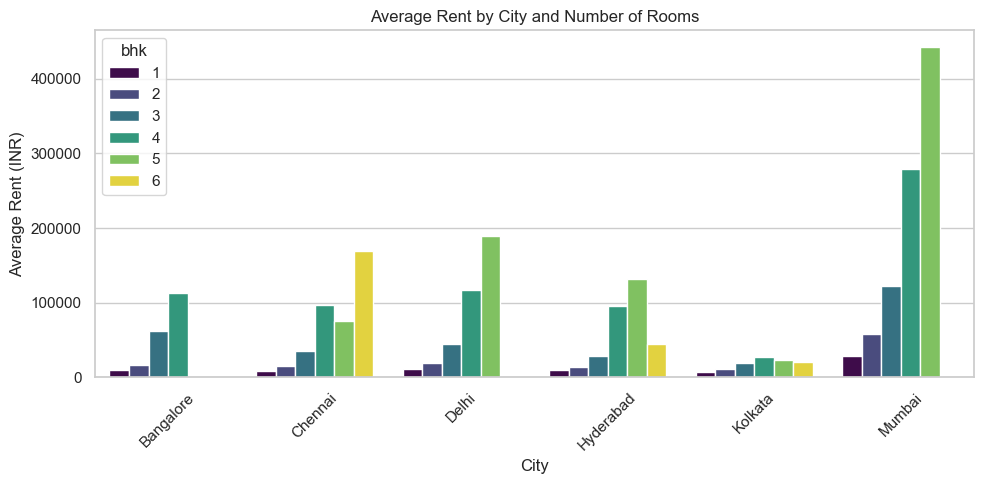

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.barplot(
    data=avg_rent_by_bhk_city,
    x="city",
    y="avg_rent",
    hue="bhk",
    palette="viridis"  # Puedes probar 'viridis', 'mako', 'rocket', etc.
)
plt.title("Average Rent by City and Number of Rooms")
plt.ylabel("Average Rent (INR)")
plt.xlabel("City")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
print(df_raw.sort_values(by='rent', ascending=False).head())

       posted on  bhk     rent  size         floor    area type  \
1837  2022-06-08    3  3500000  2500    4 out of 4  Carpet Area   
1001  2022-06-01    4  1200000  5000   4 out of 15  Carpet Area   
827   2022-05-18    4  1000000  3064  18 out of 45  Carpet Area   
1329  2022-06-23    4   850000  3200    2 out of 4  Carpet Area   
1459  2022-06-27    4   700000  3200  24 out of 24  Carpet Area   

                area locality       city furnishing status  tenant preferred  \
1837             Marathahalli  Bangalore    Semi-Furnished         Bachelors   
1001                     Juhu     Mumbai    Semi-Furnished  Bachelors/Family   
827     Raheja Artesia, Worli     Mumbai    Semi-Furnished            Family   
1329             Breach Candy     Mumbai         Furnished  Bachelors/Family   
1459  Lady Ratan Tower, Worli     Mumbai         Furnished  Bachelors/Family   

      bathroom point of contact  
1837         3    Contact Agent  
1001         4    Contact Agent  
827          4

C:\Users\Dixon\AppData\Local\Temp\ipykernel_36852\2641019721.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


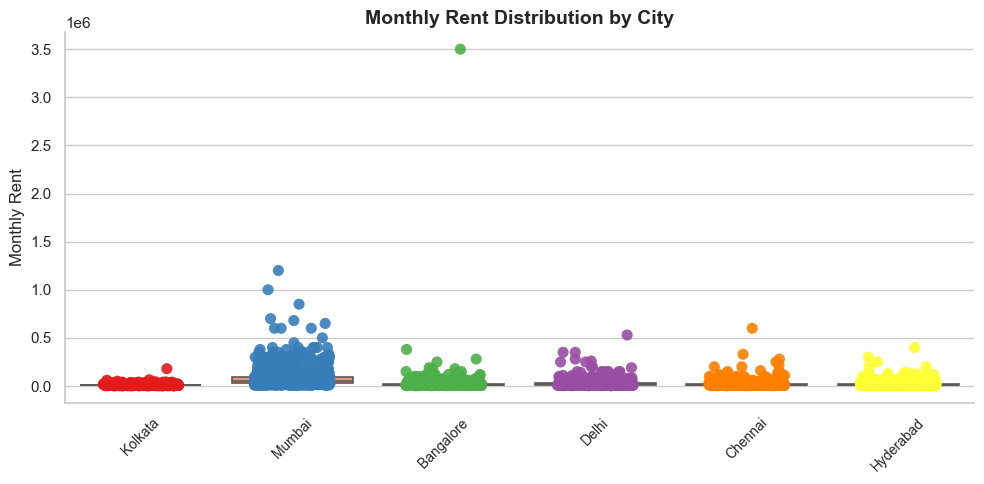

In [23]:
warnings.filterwarnings("ignore", category=FutureWarning)

plt.figure(figsize=(10, 5))
sns.boxplot(x='city', y='rent', data=df_raw, showfliers=False, palette='Set2', linewidth=1.2)
sns.stripplot(x='city', y='rent', data=df_raw, hue='city', dodge=False, palette='Set1',
    jitter=0.25, size=8, alpha=0.9)
plt.legend().remove()
plt.xticks(rotation=45, fontsize=10)
plt.title('Monthly Rent Distribution by City', fontsize=14, weight='bold')
plt.ylabel('Monthly Rent', fontsize=12)
plt.xlabel('')
sns.despine()
plt.tight_layout()
plt.show()

- El análisis de las **5 propiedades con los alquileres más altos** mostró que todas se encuentran en **Mumbai** y representan propiedades de lujo con parámetros no convencionales. Por ejemplo, las propiedades con menor superficie pueden ser más caras debido a un piso alto, posiblemente áticos u otros tipos de viviendas de lujo. Estos casos pueden **distorsionar el aprendizaje del modelo**, especialmente la regresión lineal, y requieren un filtrado o un enfoque independiente.

- Este gráfico solo muestra el valor atípico para la ciudad de **Bangalore**, necesitamos encontrarlo y verificarlo.

> **Conclusión:**  
> Es recomendable considerar **Mumbai por separado** al construir modelos para evitar distorsionar la tendencia general del mercado de alquiler.

In [24]:
df_raw.rent.sort_values(ascending=False).head(5)

1837    3500000
1001    1200000
827     1000000
1329     850000
1459     700000
Name: rent, dtype: int64

In [25]:
df_raw.loc[[1837]]

,posted on,bhk,rent,size,floor,area type,area locality,city,furnishing status,tenant preferred,bathroom,point of contact
1837,2022-06-08,3,3500000,2500,4 out of 4,Carpet Area,Marathahalli,Bangalore,Semi-Furnished,Bachelors,3,Contact Agent


Un análisis detallado muestra que esta vivienda no es líder en cuanto a superficie ni número de habitaciones, por lo que un coste tan anormalmente alto probablemente se deba a un **error**.

**Acciones tomadas:**
- Elimino esta línea del conjunto de datos.
- Corrijo los valores máximos de alquiler, limitándolos hasta el **percentil 99**.

Esto permite evitar distorsiones en el análisis y mejora la calidad de los datos para el modelado.

In [26]:
df_raw =df_raw.drop(index=[1837])

# Limitar los valores máximos de alquiler al percentil 99
upper_limit = df_raw['rent'].quantile(0.99)
df_raw = df_raw[df_raw['rent'] <= upper_limit]

Se filtra el **1% superior de los alquileres** para mejorar la estabilidad de la predicción.


> **Advertencia:**  
> La principal vulnerabilidad es la posible pérdida de precisión para las viviendas de lujo, que ahora el modelo ignora.  
> Para predecir el coste de las viviendas de lujo, recomiendo construir un **modelo independiente** con un conjunto de datos diferente solo para este segmento.

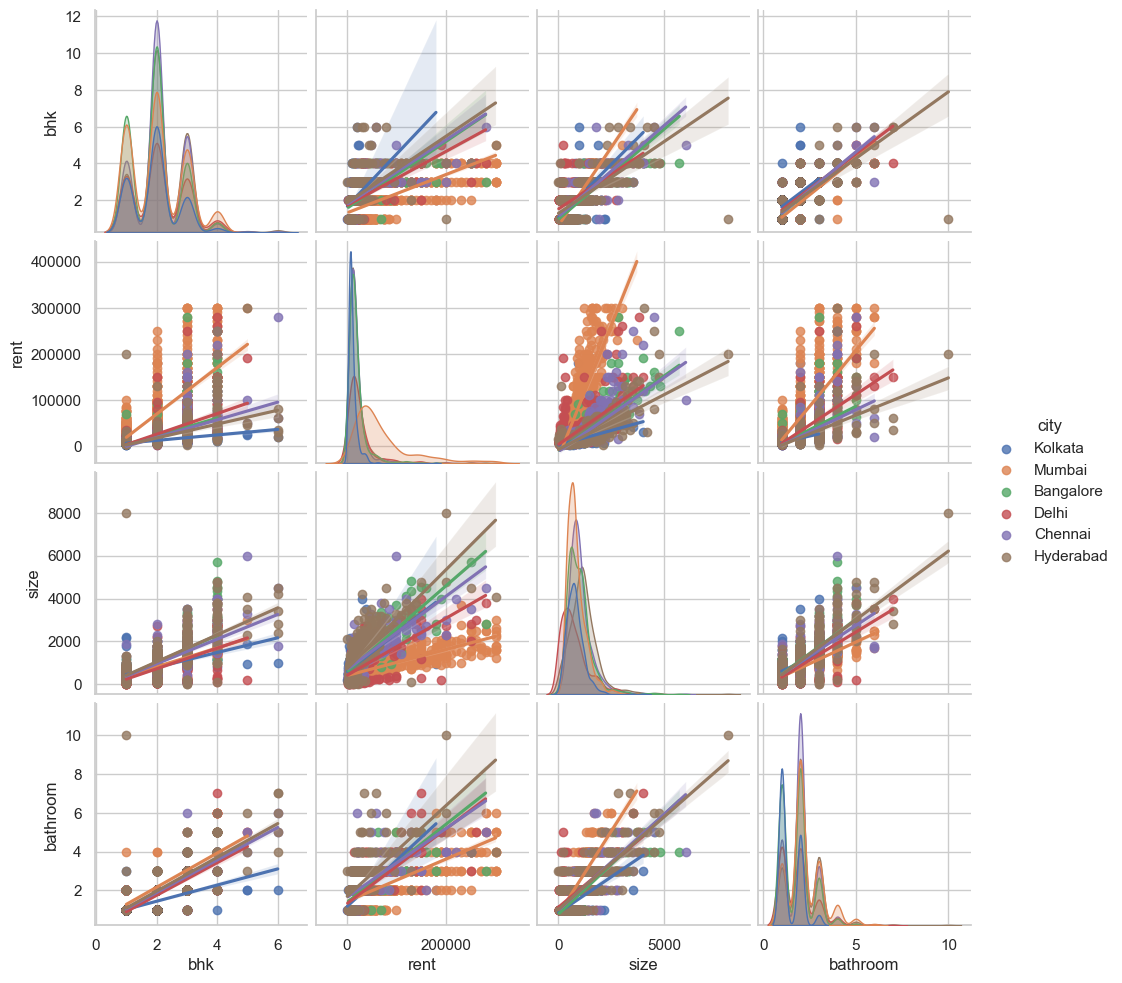

In [27]:
warnings.filterwarnings("ignore")
sns.pairplot(df_raw[['bhk', 'rent', 'size', 'furnishing status', 'bathroom', 'city']], hue='city', kind='reg')

**Análisis de los datos residuales:**  
Se detecta un valor atípico en las variables **bath** y **size** para la ciudad de **Hyderabad**.  
Es necesario investigar si se trata de un error de captura de datos.

In [28]:
df_raw.bathroom.sort_values().tail(10)

1160     6
4648     6
4543     6
1093     6
2845     6
2849     6
4518     7
2846     7
4350     7
4185    10
Name: bathroom, dtype: int64

In [29]:
df_raw.loc[[4185]]

,posted on,bhk,rent,size,floor,area type,area locality,city,furnishing status,tenant preferred,bathroom,point of contact
4185,2022-06-06,1,200000,8000,Ground out of 4,Super Area,"Beeramguda, Ramachandra Puram, NH 9",Hyderabad,Unfurnished,Bachelors/Family,10,Contact Owner


Esta vivienda cuenta con una **gran superficie** y **varios baños**, lo que justifica el alto coste. Pero, el valor de **bhk** aparece como 1, lo cual probablemente se deba a un error en el registro de este campo ya que no tiene logica.

> **Nota:**  
> Es importante revisar y corregir estos posibles errores en los datos antes de continuar con el análisis, ya que pueden afectar la calidad de los resultados.

Las columnas **Post-On** y **area locality** no aportaron valor cualitativo al análisis.  
La columna **locality** contiene más de **2000 valores únicos**, lo que dificulta su conversión a variables numéricas y puede generar problemas de dimensionalidad.  
Por estas razones, decidí **eliminar estas columnas** del conjunto de datos.

In [30]:
df_raw = df_raw.drop(index=[4185])
df_raw = df_raw.drop(columns=['posted on', 'area locality'])

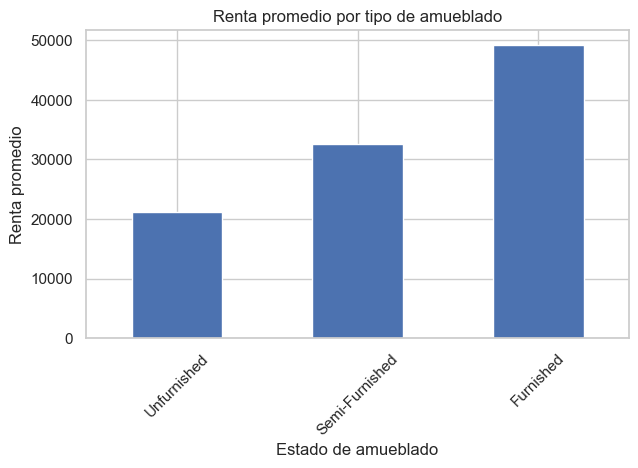

In [31]:
grouped = df_raw.groupby('furnishing status')['rent'].mean().reindex(['Unfurnished', 'Semi-Furnished', 'Furnished'])

grouped.plot(kind='bar', figsize=(7,4))
plt.title('Renta promedio por tipo de amueblado')
plt.ylabel('Renta promedio')
plt.xlabel('Estado de amueblado')
plt.xticks(rotation=45)
plt.show()

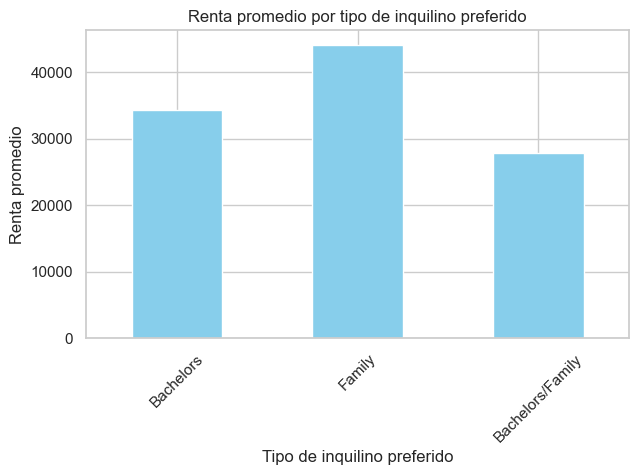

In [32]:
grouped = df_raw.groupby('tenant preferred')['rent'].mean().reindex(['Bachelors', 'Family', 'Bachelors/Family'])

grouped.plot(kind='bar', figsize=(7,4), color='skyblue')
plt.title('Renta promedio por tipo de inquilino preferido')
plt.ylabel('Renta promedio')
plt.xlabel('Tipo de inquilino preferido')
plt.xticks(rotation=45)
plt.show()

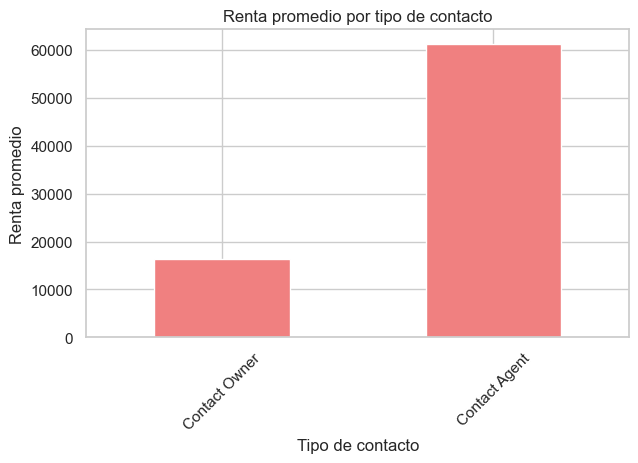

In [33]:
grouped = df_raw.groupby('point of contact')['rent'].mean().reindex(['Contact Owner', 'Contact Agent'])

grouped.plot(kind='bar', figsize=(7,4), color='lightcoral')
plt.title('Renta promedio por tipo de contacto')
plt.ylabel('Renta promedio')
plt.xlabel('Tipo de contacto')
plt.xticks(rotation=45)
plt.show()

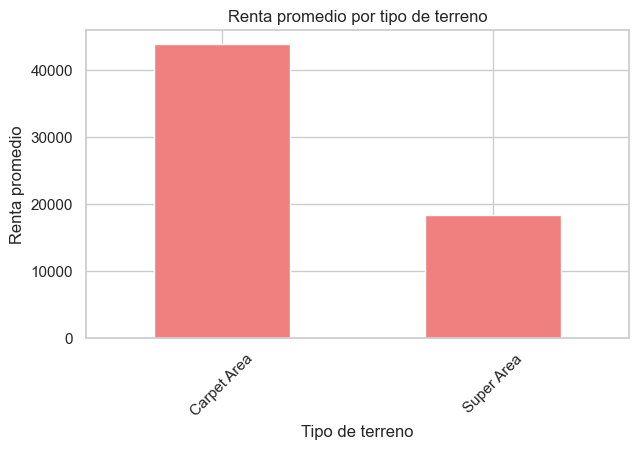

In [34]:
grouped = df_raw.groupby('area type')['rent'].mean()

grouped.plot(kind='bar', figsize=(7,4), color='lightcoral')
plt.title('Renta promedio por tipo de terreno')
plt.ylabel('Renta promedio')
plt.xlabel('Tipo de terreno')
plt.xticks(rotation=45)
plt.show()

- para la variable `area_type`,`tenant_prefered` y `point_of_contact` realizaremos un **one-hot-encoding** ya que solo tenemos dos datos de cada una y el modelo entrenaria mejor aunque se vea coo las medias auentan progresivamente. 
- para la variable `furnish_status`establecemos un **ordinal encoding** ya que podemos ver que teneoms una ordinalidad unfurnised>semi-furnished>furnished y la renta media aunmente segun pasamos de un estado a otro. 

### Comprobacion de la distribucion del target 


Text(0.5, 1.0, 'Distribución de renta')

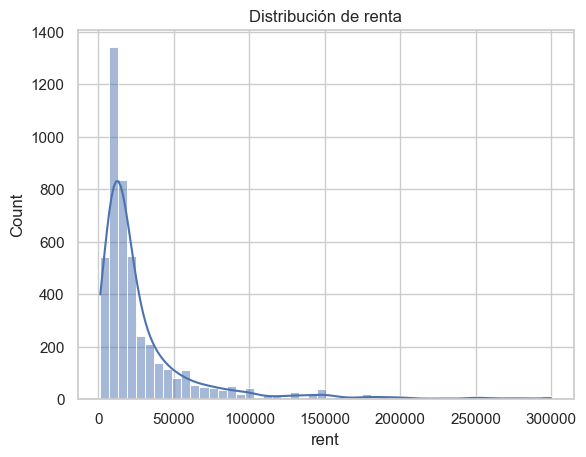

In [35]:
sns.histplot(df_raw['rent'], bins=50, kde=True)
plt.title("Distribución de renta")

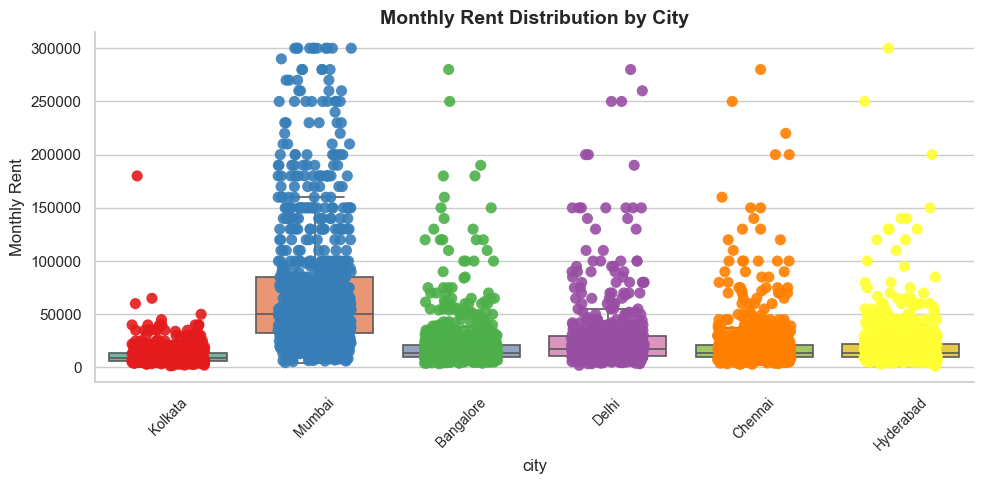

In [36]:
#boxplot para ver la distribución de la renta
plt.figure(figsize=(10, 5))
sns.boxplot(x='city', y='rent', data=df_raw, showfliers=False, palette='Set2', linewidth=1.2)
sns.stripplot(x='city', y='rent', data=df_raw, hue='city', dodge=False, palette='Set1',
    jitter=0.25, size=8, alpha=0.9)
plt.legend().remove()
plt.xticks(rotation=45, fontsize=10)
plt.title('Monthly Rent Distribution by City', fontsize=14, weight='bold')
plt.ylabel('Monthly Rent', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()




- El ultimo grafico reafirma la conclusion de que en Bombay los precios son mucho mas alto, posiblemente por la vivienda de lujo por lo que separaremos los modelos para nos sesgar el resto de ciudaddes.  

#### Normalizacion logaritmica de la variable **rent**

In [37]:

rent_skew_value = skew(df_raw['rent'])
print(f"Skewness: {rent_skew_value:.2f}")

Skewness: 3.47


In [38]:
df_raw['log_rent'] = np.log1p(df_raw['rent'])



In [39]:
#comparar la distribución original y la logarítmica
print("Comparación de la distribución original y logarítmica:")
print("skewness original: ", skew(df_raw['rent']))
print("skewness logarítmica: ", skew(df_raw['log_rent']))


Comparación de la distribución original y logarítmica:
skewness original:  3.469737390736441
skewness logarítmica:  0.7384210978806498


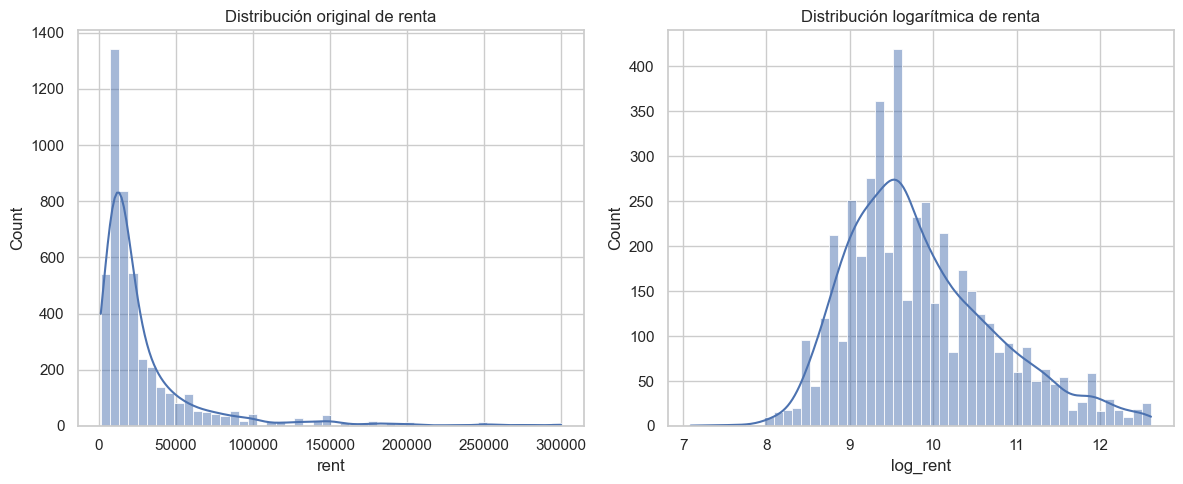

In [40]:
#Representación gráfica de la distribución original y logarítmica

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_raw['rent'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribución original de renta')

sns.histplot(df_raw['log_rent'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribución logarítmica de renta')

plt.tight_layout()
plt.show()


- al ver como la distribucion de la renta tiene una cola mas larga y no tiene una distribucion normal, tendemos a normalizarla con el logaritmo para posteriormente comparar los resultados de ambos modelos y elegir el que mejor rendimiento tenga .

Text(0.5, 1.0, 'Distribución de tamaño')

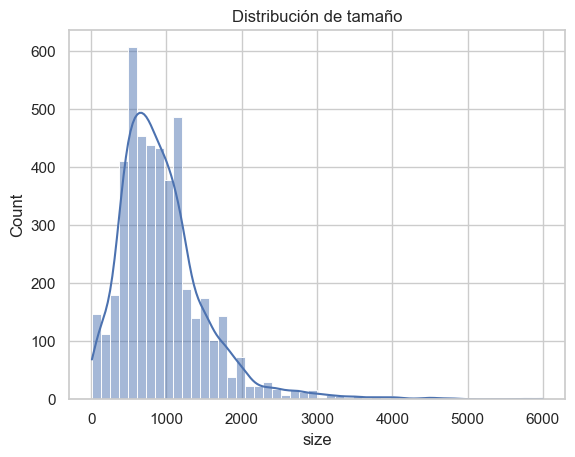

In [41]:
sns.histplot(df_raw['size'], bins=50, kde=True)
plt.title("Distribución de tamaño")

In [42]:
size_skew_value = skew(df_raw['size'])
print(f"Skewness: {size_skew_value:.2f}")

Skewness: 1.94


In [43]:
df_raw['log_size'] = np.log1p(df_raw['size'])

In [44]:
df_raw.head()

,bhk,rent,size,floor,area type,city,furnishing status,tenant preferred,bathroom,point of contact,log_rent,log_size
0,2,10000,1100,Ground out of 2,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,9.210440,7.003974
1,2,20000,800,1 out of 3,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,9.903538,6.685861
2,2,17000,1000,1 out of 3,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,9.741027,6.908755
3,2,10000,800,1 out of 2,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,9.210440,6.685861
4,2,7500,850,1 out of 2,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner,8.922792,6.746412


In [45]:
#comparar la distribución original y la logarítmica
print("Comparación de la distribución original y logarítmica:")
print("skewness original: ", skew(df_raw['size']))
print("skewness logarítmica: ", skew(df_raw['log_size']))

Comparación de la distribución original y logarítmica:
skewness original:  1.9428886775007865
skewness logarítmica:  -1.1703081883283564


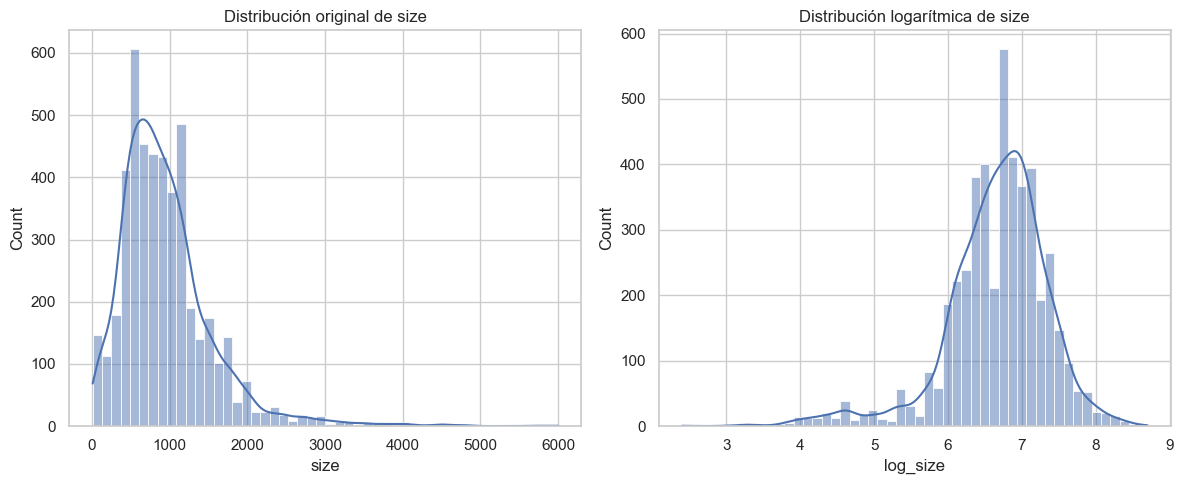

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_raw['size'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribución original de size')

sns.histplot(df_raw['log_size'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribución logarítmica de size')

plt.tight_layout()
plt.show()

## 2. Feature Ingeneering

#### Ingeniería de variables: características de piso

Se han creado nuevas variables a partir de la columna original **floor** para enriquecer el análisis y el modelado:

- **floor_number**: Número de piso en el que se encuentra la vivienda.
- **total_floors**: Número total de pisos del edificio.
- **is_ground_floor**: Indicador binario (0/1) si la vivienda está en planta baja.
- **is_top_floor**: Indicador binario (0/1) si la vivienda está en la última planta.
- **floor_ratio**: Proporción del piso respecto al total de pisos (`floor_number / total_floors`).

Estas variables permiten capturar el efecto de la ubicación vertical de la vivienda en el edificio, lo cual puede influir en el precio del alquiler y en las preferencias de los inquilinos.


In [47]:
df_raw['floor'].unique()

array(['Ground out of 2', '1 out of 3', '1 out of 2', 'Ground out of 1',
       'Ground out of 4', '1 out of 4', '1 out of 1', 'Ground out of 3',
       '2 out of 3', '4 out of 5', '2 out of 2', '2 out of 5',
       '4 out of 14', '3 out of 3', '5 out of 5', '4 out of 4',
       '7 out of 8', '2 out of 4', '3 out of 4', '1 out of 5',
       '8 out of 5', 'Ground out of 6', '2 out of 1',
       'Upper Basement out of 4', 'Ground out of 5', '3 out of 5',
       '11 out of 19', '5 out of 10', '11 out of 14',
       'Lower Basement out of 2', '2 out of 7', '4 out of 10',
       '7 out of 10', '2 out of 13', '6 out of 7', '4 out of 7',
       '14 out of 14', '43 out of 78', '2 out of 8', '13 out of 18',
       '5 out of 12', '18 out of 24', '3 out of 7', '11 out of 21',
       '7 out of 19', '14 out of 23', '9 out of 20',
       'Upper Basement out of 9', '19 out of 24', '3 out of 21',
       '1 out of 22', '8 out of 8', '6 out of 12', '4 out of 58',
       'Upper Basement out of 16', '60 o

In [48]:
def parse_floor(value):
    if pd.isnull(value):
        return np.nan, np.nan
    value = value.strip()
    if 'Ground' in value:
        total = int(value.split('out of')[1].strip()) if 'out of' in value else np.nan
        return 0, total
    elif 'Upper Basement' in value:
        total = int(value.split('out of')[1].strip())
        return -1, total
    elif 'Lower Basement' in value:
        total = int(value.split('out of')[1].strip())
        return -2, total
    elif 'out of' in value:
        parts = value.split('out of')
        floor = int(parts[0].strip())
        total = int(parts[1].strip())
        return floor, total
    elif value.isdigit():
        return int(value), np.nan
    else:
        return np.nan, np.nan

# Crear columnas 'floor_number' y 'total_floors' a partir de la columna 'Floor'
df_raw[['floor_number', 'total_floors']] = df_raw['floor'].apply(lambda x: pd.Series(parse_floor(x)))

In [49]:
df_raw.head(5)


,bhk,rent,size,floor,area type,city,furnishing status,tenant preferred,bathroom,point of contact,log_rent,log_size,floor_number,total_floors
0,2,10000,1100,Ground out of 2,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,9.210440,7.003974,0.0,2.0
1,2,20000,800,1 out of 3,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,9.903538,6.685861,1.0,3.0
2,2,17000,1000,1 out of 3,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,9.741027,6.908755,1.0,3.0
3,2,10000,800,1 out of 2,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,9.210440,6.685861,1.0,2.0
4,2,7500,850,1 out of 2,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner,8.922792,6.746412,1.0,2.0


In [50]:
print(df_raw['total_floors'].isnull().sum())
#eliminar nulos si es necesario
df_raw = df_raw.dropna(subset=['total_floors'])

4


In [51]:

def add_floor_features(df):
    """
    Añade columnas derivadas de la información de pisos:
    - is_ground_floor
    - is_top_floor
    - floor_ratio
    
    Requiere que el DataFrame tenga las columnas:
    - 'floor_number'
    - 'total_floors'
    
    Devuelve el DataFrame con las nuevas columnas añadidas.
    """
    
    # Asegurar tipos numéricos
    df['floor_number'] = pd.to_numeric(df['floor_number'], errors='coerce')
    df['total_floors'] = pd.to_numeric(df['total_floors'], errors='coerce')
    
    # Planta baja
    df['is_ground_floor'] = (df['floor_number'] == 0).astype(int)
    
    # Última planta
    df['is_top_floor'] = (df['floor_number'] == df['total_floors']).astype(int)
    
    # Proporción de piso respecto al total
    df['floor_ratio'] = np.where(
        (df['floor_number'].notna()) & (df['total_floors'] > 0),
        np.round(df['floor_number'] / df['total_floors'], 3),
        np.nan
    )
    
    return df


In [52]:
df_raw = add_floor_features(df_raw)

In [53]:
#como ya tenemos codificadas las columans de piso, podemos eliminar la columna original
df_raw = df_raw.drop(columns=['floor'])

In [54]:
df_raw.head(5)


,bhk,rent,size,area type,city,furnishing status,tenant preferred,bathroom,point of contact,log_rent,log_size,floor_number,total_floors,is_ground_floor,is_top_floor,floor_ratio
0,2,10000,1100,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,9.210440,7.003974,0.0,2.0,1,0,0.000
1,2,20000,800,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,9.903538,6.685861,1.0,3.0,0,0,0.333
2,2,17000,1000,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,9.741027,6.908755,1.0,3.0,0,0,0.333
3,2,10000,800,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,9.210440,6.685861,1.0,2.0,0,0,0.500
4,2,7500,850,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner,8.922792,6.746412,1.0,2.0,0,0,0.500


In [55]:
df_raw.groupby('is_ground_floor')['rent'].mean()
df_raw.groupby('is_top_floor')['rent'].mean()

is_top_floor
0    31425.621075
1    23409.957404
Name: rent, dtype: float64

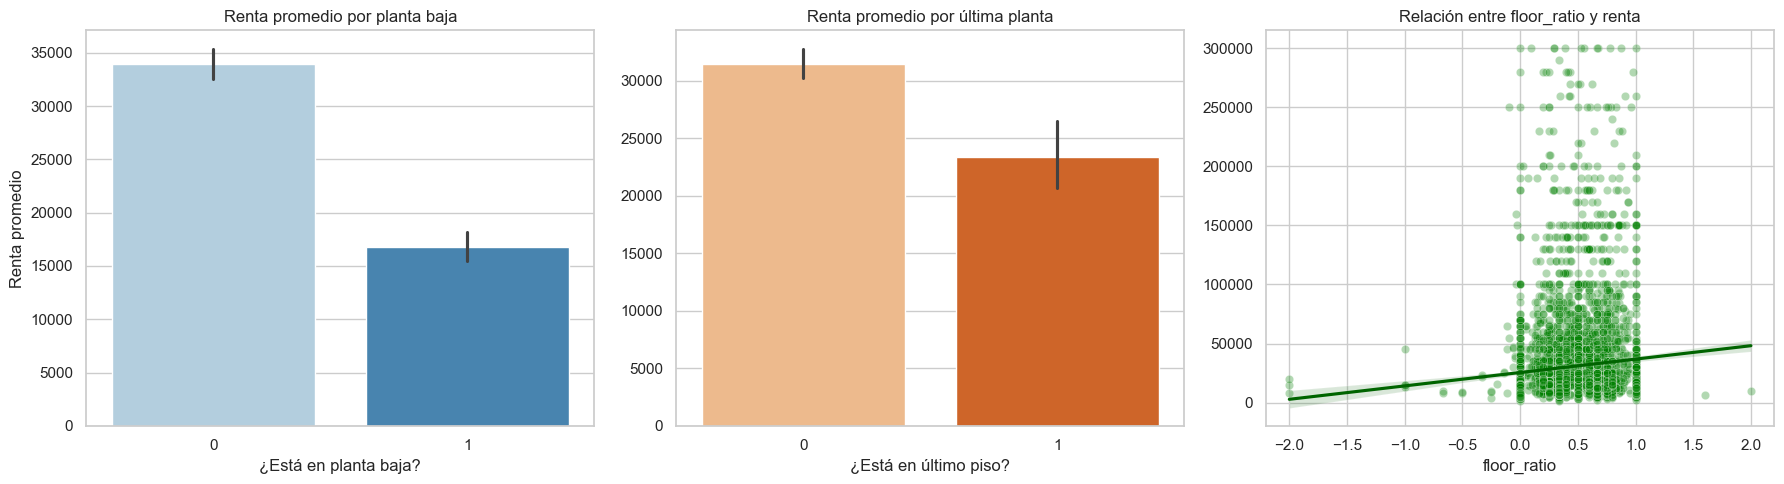

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: Renta promedio según is_ground_floor
sns.barplot(
    x='is_ground_floor',
    y='rent',
    data=df_raw,
    ax=axes[0],
    palette='Blues'
)
axes[0].set_title('Renta promedio por planta baja')
axes[0].set_xlabel('¿Está en planta baja?')
axes[0].set_ylabel('Renta promedio')

# Gráfico 2: Renta promedio según is_top_floor
sns.barplot(
    x='is_top_floor',
    y='rent',
    data=df_raw,
    ax=axes[1],
    palette='Oranges'
)
axes[1].set_title('Renta promedio por última planta')
axes[1].set_xlabel('¿Está en último piso?')
axes[1].set_ylabel('')

# Gráfico 3: Relación entre floor_ratio y renta
sns.scatterplot(
    x='floor_ratio',
    y='rent',
    data=df_raw,
    ax=axes[2],
    alpha=0.3,
    color='green'
)
sns.regplot(
    x='floor_ratio',
    y='rent',
    data=df_raw,
    ax=axes[2],
    scatter=False,
    color='darkgreen'
)
axes[2].set_title('Relación entre floor_ratio y renta')
axes[2].set_xlabel('floor_ratio')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

-  Vemos como las rentas de los pisos que si estan en planta baja (`is_ground_floor` = 1) tienen una media de renta mucho menor que los que no estan en planta baja (`is_ground_floo`= 1) asi como ocurre con los que estan en un atico/ultimo piso (`is_top_floor`=1) tienen una renta menor que las que estan en pisos intermedios. 

- Las variables `is_ground_floor` y `is_top_floor` son predictores muy potentes debido a las claras diferencias en las rentas promedio. La variable continua floor_ratio es un predictor más débil pero útil, que captura una tendencia sutil. En conjunto, estos gráficos confirman que la ubicación vertical del piso es fundamental para determinar su precio de alquiler en el dataset.

- Como podemos ver algunos datos de la variable `floor_ratio` son valores negativos por lo que puede sesgar nuestro modelo, a continuacion veremos las cantidad de datos en relacion del dataset para ver si nuestro modelo se puede ver sesgado de manera negativa y con ello influir negativamente en las predicciones del modelo. 

In [57]:
total_filas = df_raw.shape[0]

negativos = df_raw[df_raw['floor_ratio'] < 0].shape[0]

porcentaje = round((negativos / total_filas) * 100,4)
print(f"Porcentaje de valores negativos totales",porcentaje,"%")

Porcentaje de valores negativos totales 0.6813 %


- Al ser un porcentaje tan pequeño, consideramos que lo mas correcto para que no influya en el desempeño del modelo así como considerar que tan pocos valores no serviran a nuestro modelo en el entrenamiento, procedemos a eliminar esos datos. 

In [58]:
df_raw = df_raw[df_raw['floor_ratio'] >= 0]

#### Codificación de la variable `furnishing status`

La variable **furnishing status** representa el nivel de amueblamiento de la vivienda y se ha transformado en una variable ordinal para facilitar el modelado:

- **Unfurnished** → 0
- **Semi-Furnished** → 1
- **Furnished** → 2

Esta codificación permite que los algoritmos de machine learning interpreten correctamente el grado de amueblamiento y su posible impacto en el precio del alquiler.

In [59]:

def encode_furnishing_status(df, column='furnishing status'):
    """
    Codifica la columna 'Furnishing Status' como una variable ordinal:
    - Unfurnished = 0
    - Semi-Furnished = 1
    - Furnished = 2
    
    Si encuentra valores no esperados, los marca como NaN.
    Devuelve el DataFrame con la nueva columna 'furnishing_encoded'.
    """
    
    mapping = {
        'Unfurnished': 0,
        'Semi-Furnished': 1,
        'Furnished': 2
    }
    
    df['furnishing_encoded'] = df[column].map(mapping)
    
    return df


In [60]:
df_raw = encode_furnishing_status(df_raw)

In [61]:
df_raw.head(5)

,bhk,rent,size,area type,city,furnishing status,tenant preferred,bathroom,point of contact,log_rent,log_size,floor_number,total_floors,is_ground_floor,is_top_floor,floor_ratio,furnishing_encoded
0,2,10000,1100,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,9.210440,7.003974,0.0,2.0,1,0,0.000,0
1,2,20000,800,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,9.903538,6.685861,1.0,3.0,0,0,0.333,1
2,2,17000,1000,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,9.741027,6.908755,1.0,3.0,0,0,0.333,1
3,2,10000,800,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,9.210440,6.685861,1.0,2.0,0,0,0.500,0
4,2,7500,850,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner,8.922792,6.746412,1.0,2.0,0,0,0.500,0


In [62]:
df_raw = df_raw.drop(columns=['furnishing status'])

In [63]:
df_raw.head()

,bhk,rent,size,area type,city,tenant preferred,bathroom,point of contact,log_rent,log_size,floor_number,total_floors,is_ground_floor,is_top_floor,floor_ratio,furnishing_encoded
0,2,10000,1100,Super Area,Kolkata,Bachelors/Family,2,Contact Owner,9.210440,7.003974,0.0,2.0,1,0,0.000,0
1,2,20000,800,Super Area,Kolkata,Bachelors/Family,1,Contact Owner,9.903538,6.685861,1.0,3.0,0,0,0.333,1
2,2,17000,1000,Super Area,Kolkata,Bachelors/Family,1,Contact Owner,9.741027,6.908755,1.0,3.0,0,0,0.333,1
3,2,10000,800,Super Area,Kolkata,Bachelors/Family,1,Contact Owner,9.210440,6.685861,1.0,2.0,0,0,0.500,0
4,2,7500,850,Carpet Area,Kolkata,Bachelors,1,Contact Owner,8.922792,6.746412,1.0,2.0,0,0,0.500,0


#### One Hot Encoding para las variables categoricas    

In [64]:
categorical_cols = ['area type', 'city', 'tenant preferred', 'point of contact']
df_encoded = pd.get_dummies(df_raw, columns=categorical_cols, drop_first=True)

In [65]:
print(df_encoded.head())

   bhk   rent  size  bathroom  log_rent  log_size  floor_number  total_floors  \
0    2  10000  1100         2  9.210440  7.003974           0.0           2.0   
1    2  20000   800         1  9.903538  6.685861           1.0           3.0   
2    2  17000  1000         1  9.741027  6.908755           1.0           3.0   
3    2  10000   800         1  9.210440  6.685861           1.0           2.0   
4    2   7500   850         1  8.922792  6.746412           1.0           2.0   

   is_ground_floor  is_top_floor  ...  furnishing_encoded  \
0                1             0  ...                   0   
1                0             0  ...                   1   
2                0             0  ...                   1   
3                0             0  ...                   0   
4                0             0  ...                   0   

   area type_Super Area  city_Chennai  city_Delhi  city_Hyderabad  \
0                  True         False       False           False   
1       

In [66]:
df_encoded.to_csv('../data/df_encoded.csv',index=False)

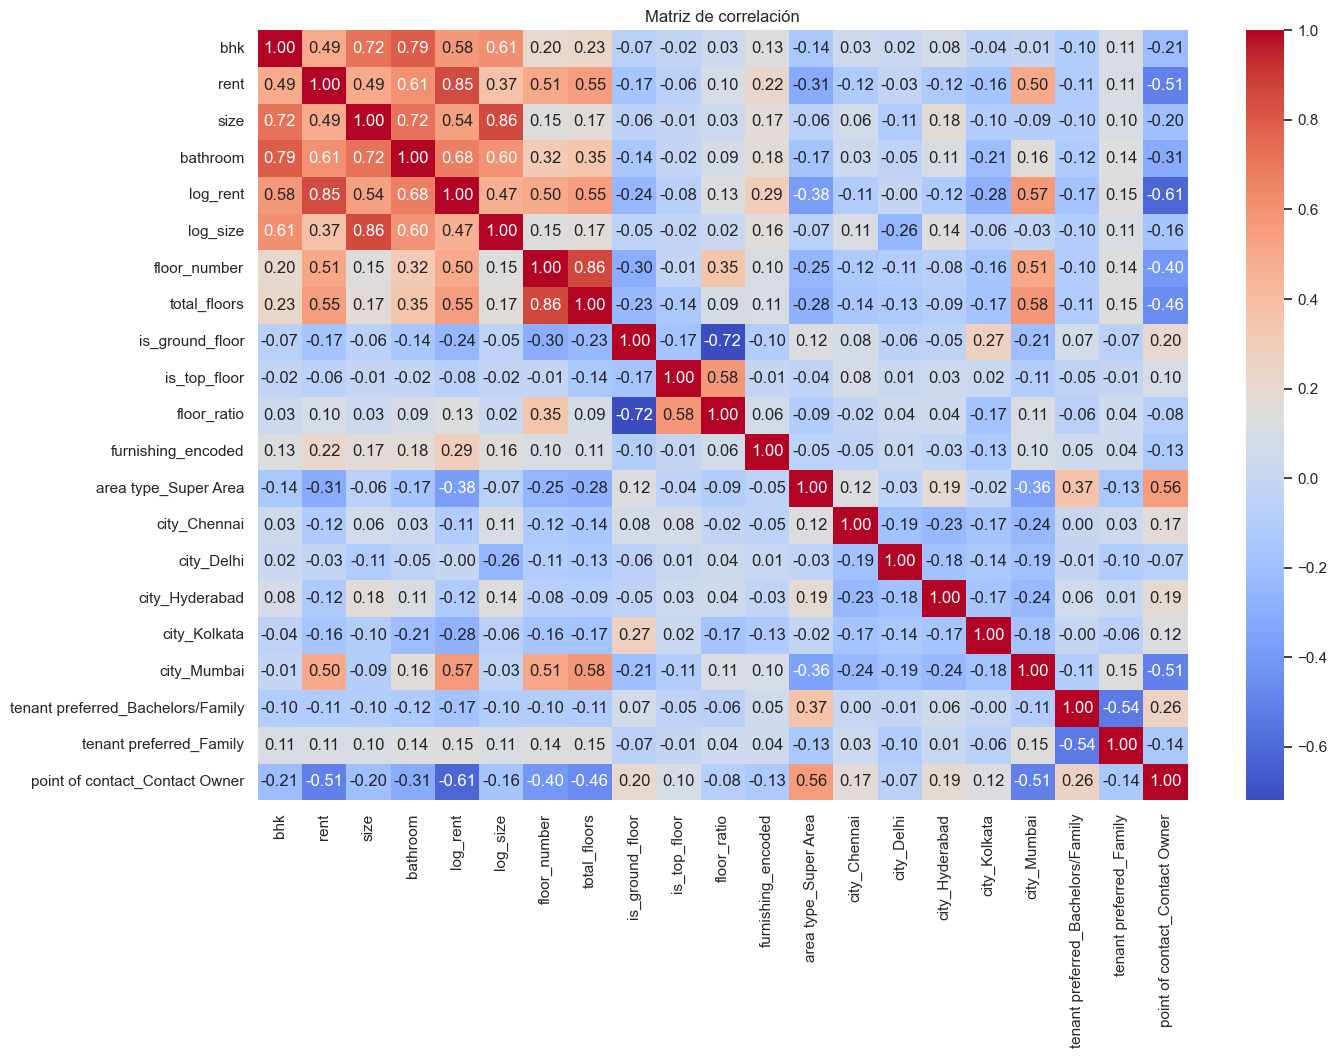

In [67]:
# Calcular la matriz de correlación
correlation_matrix = df_encoded.corr()
# hacer heatmap
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()

# PCA
Se va a determinar cuáles son las variables que aportan mas para la predicción de la renta:

Ajuste realizado. Se excluyeron las siguientes columnas: ['log_size', 'log_rent']
Columnas utilizadas para el PCA: ['bhk', 'size', 'bathroom', 'floor_number', 'total_floors', 'is_ground_floor', 'is_top_floor', 'floor_ratio', 'furnishing_encoded', 'area type_Super Area', 'city_Chennai', 'city_Delhi', 'city_Hyderabad', 'city_Kolkata', 'city_Mumbai', 'tenant preferred_Bachelors/Family', 'tenant preferred_Family', 'point of contact_Contact Owner']

Gráfico de varianza acumulada ajustado guardado como 'cumulative_variance_adjusted.png'

Se analizarán los primeros 13 componentes (cubren >95% de la varianza).

Loadings de las variables en los primeros componentes principales (Ajustado):
                                        PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8       PC9      PC10      PC11      PC12      PC13
bhk                                0.268217  0.471531 -0.025633 -0.032293  0.149880  0.019763  0.144287 -0.094045  0.104211 -0.066820  0.106632  0.

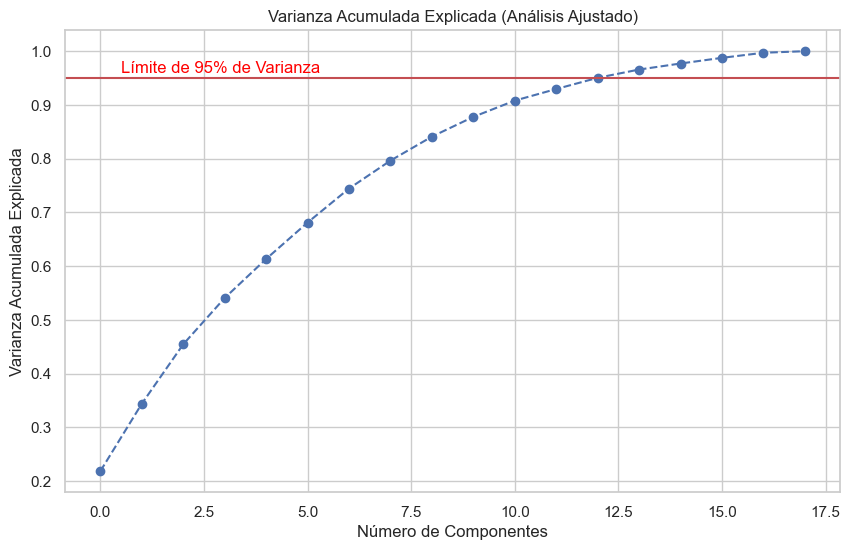

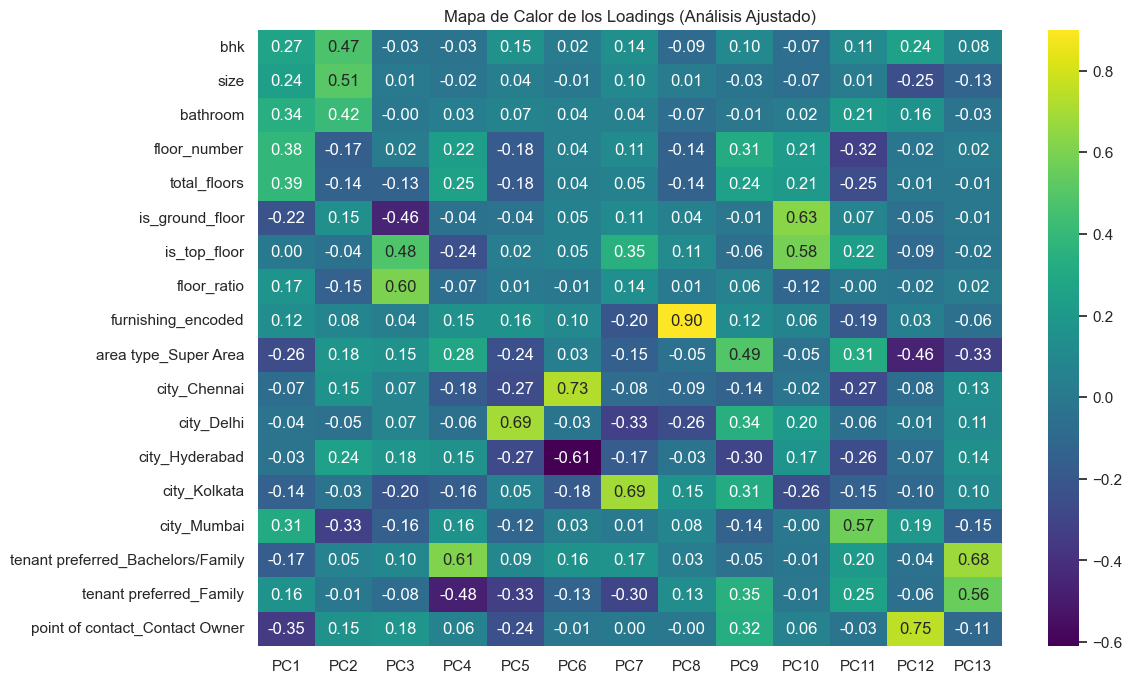

In [70]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Separar las variables predictoras (X) de la variable objetivo (y)
# Se asume que la columna objetivo se llama 'rent' en minúsculas como en el código original.
X = df_encoded.drop('rent', axis=1)
y = df_encoded['rent']


# 2. AJUSTE: Excluir 'log_size' y 'log_rent' para evitar multicolinealidad
# Se eliminan explícitamente las columnas transformadas para no incluirlas en el PCA.
columns_to_exclude = ['log_size', 'log_rent']
# Nos aseguramos de que solo se intenten eliminar las columnas que realmente existen en el DataFrame
existing_columns_to_exclude = [col for col in columns_to_exclude if col in X.columns]

if existing_columns_to_exclude:
    X = X.drop(columns=existing_columns_to_exclude)
    print(f"Ajuste realizado. Se excluyeron las siguientes columnas: {existing_columns_to_exclude}")
else:
    print("No se encontraron las columnas 'log_size' o 'log_rent' para excluir.")


# Guardamos los nombres de las columnas que sí se usarán en el análisis
feature_names = X.columns
print(f"Columnas utilizadas para el PCA: {feature_names.tolist()}")


# 3. Escalar los datos
# PCA es sensible a la escala de las variables, por lo que es fundamental estandarizarlas.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# 4. Aplicar PCA
# Creamos una instancia de PCA. Al no definir n_components, se calcularán todos los posibles.
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


# 5. Determinar el número de componentes a mantener (Criterio de Varianza)
# Graficamos la varianza acumulada explicada por los componentes.
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Varianza Acumulada Explicada (Análisis Ajustado)')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada Explicada')
plt.grid(True)
# Añadimos una línea en el 95% para ver cuántos componentes necesitamos para alcanzar ese umbral.
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.96, 'Límite de 95% de Varianza', color = 'red', fontsize=12)
plt.savefig('cumulative_variance_adjusted.png')
print("\nGráfico de varianza acumulada ajustado guardado como 'cumulative_variance_adjusted.png'")


# 6. Analizar los "Loadings" de los componentes
# Los "loadings" nos dicen qué tanto peso tiene cada variable original en cada componente.

# Determinamos dinámicamente cuántos componentes analizar para llegar al 95% de varianza
try:
    n_components_to_analyze = (np.cumsum(pca.explained_variance_ratio_) < 0.95).sum() + 1
except:
    # Si solo hay un componente, se analiza ese.
    n_components_to_analyze = 1

print(f"\nSe analizarán los primeros {n_components_to_analyze} componentes (cubren >95% de la varianza).")


loadings = pd.DataFrame(
    pca.components_[:n_components_to_analyze].T, # Usamos la transpuesta para tener variables en filas
    columns=[f'PC{i+1}' for i in range(n_components_to_analyze)],
    index=feature_names
)

print("\nLoadings de las variables en los primeros componentes principales (Ajustado):")
print(loadings.to_string())


# Para visualizarlo mejor, podemos usar un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, annot=True, cmap='viridis', fmt='.2f')
plt.title('Mapa de Calor de los Loadings (Análisis Ajustado)')
plt.savefig('loadings_heatmap_adjusted.png')
print("\nMapa de calor de los loadings ajustado guardado como 'loadings_heatmap_adjusted.png'")


In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# APLICAR PCA CON 13 COMPONENTES
# Basado en el análisis, establecemos n_components=13
n_components = 13
pca = PCA(n_components=n_components)

# Ajustamos PCA a los datos escalados y los transformamos
X_pca = pca.fit_transform(X_scaled)

# Creamos un nuevo DataFrame con los componentes principales
# Este será nuestro nuevo conjunto de características (features)
df_pca = pd.DataFrame(
    data=X_pca,
    columns=[f'Componente Principal {i+1}' for i in range(n_components)]
)

print("--- Nuevo DataFrame con 13 Componentes Principales ---")
print(df_pca.head())

# 4. ENTRENAR UN MODELO DE PREDICCIÓN CON LOS COMPONENTES
# Ahora usamos df_pca como nuestras 'X' para entrenar el modelo.

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_pca, y, test_size=0.2, random_state=42)

--- Nuevo DataFrame con 13 Componentes Principales ---
   Componente Principal 1  Componente Principal 2  Componente Principal 3  \
0               -2.352015                0.924657               -2.232247   
1               -1.835481               -0.266755               -0.408393   
2               -1.755664               -0.097087               -0.406284   
3               -1.965854               -0.444336               -0.134928   
4               -1.036780               -0.882344               -0.647537   

   Componente Principal 4  Componente Principal 5  Componente Principal 6  \
0                0.011382               -0.097309               -0.495004   
1                0.294688                0.090964               -0.508345   
2                0.287719                0.103614               -0.510873   
3                0.011434               -0.121875               -0.660728   
4               -1.924572                0.161639               -1.066729   

   Componente Princ

## Conclusión del Análisis de Componentes Principales (PCA)
Tras analizar los resultados obtenidos, se concluye que el número óptimo de componentes principales a utilizar para el modelo de predicción es de 13.

Esta recomendación se fundamenta en el gráfico de "Varianza Acumulada Explicada". En dicho gráfico, se observa que es con 13 componentes cuando la varianza acumulada supera el umbral del 95%, lo que garantiza que se retiene la mayor parte de la información estructural de los datos, descartando el ruido y la redundancia menos significativa.

Adicionalmente, el análisis de los "loadings" a través del mapa de calor y la tabla de datos confirma que estos 13 componentes capturan de manera lógica las características más importantes de las viviendas, como sus dimensiones, ubicación y atributos específicos del piso.

## 3. Entrenamiento de modelos. 

- Entrenar diferentes modelos: 

    - Con y sin Mumbai 
    - Con y sin normalizaciones logaritmicas

    - Orden de modelos: 
        1) Ridge, evitamos multicolinaliedad. 
        2) RandomForestRegressor y XGboosRegressor 

    >*Comprobar rendimiento del MAE,RMSE y R2*

    - Elegir el que mejor rendimiento tenga: 

        - Ajustar hiperparametros.

    >*Comprobar rendimiento del MAE,RMSE y R2*


### 3.1 Modelos sin normalización logaritmica en variables `rent` y `size`

#### Modelos sin Bombay 

#### Modelos con bombay 

### 3.2 Modelos con normalización logaritmica en variables `rent` y `size`

#### Modelos sin Bombay 

#### Modelos con Bombay 

#### 3.3 Resumen y comparativas de modelos 
- Creamos un cuadro de comparacion para ver el rendimiento de cada uno 
- Comparamos metricas MAE, RMSE y R2

## 4. Predicciones. 

## 5. Conclusiones
